In [94]:
# because I can never seem to selec the right kernel, 
# this is a quick check for that
import os
os.getcwd()

'/master-thesis-project'

In [95]:
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)

# Read the CSV file for pill composition
composition_df = pd.read_excel('data/composition.xlsx')
# replace 'X' with 'UNSAFE' and empty space with 'SAFE'
composition_df = composition_df.replace({'X': 'UNSAFE', pd.NaT: 'SAFE'})
# reset the indicies
composition_df.reset_index(drop=True, inplace=True)

composition_df

,Unnamed: 0,levonorgestrel,ulipristalacetat,"cellulosa, mikrokristallin",laktosmonohydrat,poloxamer 188,kroskarmellosnatrium,magnesiumstearat,povidon,polyvinylalkohol (E1203),...,polysorbat 80 (E433),"järnoxid, gul (E172)",kaliumaluminiumsilikat (E555),potatisstärkelse,majsstärkelse,"kiseldioxid, kolloidal, vattenfri",natriumstärkelseglykolat,hypromellos (E464),hydroxipropylcellulosa (E463),stearinsyra (E570)
0,Norlevo,UNSAFE,SAFE,SAFE,UNSAFE,SAFE,SAFE,UNSAFE,UNSAFE,SAFE,...,SAFE,SAFE,SAFE,SAFE,UNSAFE,UNSAFE,SAFE,SAFE,SAFE,SAFE
1,Postinor,UNSAFE,SAFE,SAFE,UNSAFE,SAFE,SAFE,UNSAFE,SAFE,SAFE,...,SAFE,SAFE,SAFE,UNSAFE,UNSAFE,UNSAFE,SAFE,SAFE,SAFE,SAFE
2,Levodonna,UNSAFE,SAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,SAFE,SAFE,...,SAFE,SAFE,SAFE,SAFE,SAFE,SAFE,SAFE,SAFE,SAFE,SAFE
3,ellaOne,SAFE,UNSAFE,SAFE,UNSAFE,SAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,...,UNSAFE,UNSAFE,UNSAFE,SAFE,SAFE,SAFE,SAFE,SAFE,SAFE,SAFE
4,Femke,SAFE,UNSAFE,SAFE,UNSAFE,SAFE,SAFE,UNSAFE,SAFE,SAFE,...,SAFE,SAFE,SAFE,SAFE,UNSAFE,SAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE


In [96]:
# same as above, but for the contraindications
contraindication_df = pd.read_excel('data/contraindications.xlsx')
contraindication_df = contraindication_df.replace({'X': 'UNSAFE', pd.NaT: 'SAFE'})
contraindication_df.reset_index(drop=True, inplace=True)

contraindication_df

,Unnamed: 0,Hepatic insufficiency,Astma (if glucocorticoids),Hypericum perforatum (St. John's wort),Epilepsy,HIV,Tubercolosis,Fungal infections (Griseofulvin),Ectopic pregnancy,Salpingitis,"Severe malabsorption disorder (e.g., Chron’s)",Elevated risk for thromboembolism,Breastfeeding,ulipristalacetat,levonorgestrel
0,Norlevo,UNSAFE,SAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,SAFE
1,Postinor,UNSAFE,SAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,SAFE
2,Levodonna,UNSAFE,SAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,SAFE
3,ellaOne,UNSAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,SAFE,SAFE,SAFE,SAFE,UNSAFE,SAFE,UNSAFE
4,Femke,UNSAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,UNSAFE,SAFE,SAFE,SAFE,SAFE,UNSAFE,SAFE,UNSAFE


In [97]:
# parse dataframe column-headers into lists which will later be injected
# straight into the prompt of the meidicine_interpreter agent
# so that it may recognize user input terms like
# "stearinsyra" as "stearinsyra (E570)"
contras = contraindication_df.columns.to_list()
allergies = composition_df.columns.to_list()

In [98]:
import difflib

def findMostSimilarWordContras(input_word: str, threshold=0.6):
    """
    Find the most similar word with from contraindications list.
    
    Args:
    - input_word (str): Word to match
    - threshold (float): Minimum similarity ratio to consider a match (default 0.6)
    
    Returns:
    - List of most similar word or words or None if no match meets the threshold
    """
    word_list = contras
    
    # Normalize input and list words
    normalized_input = input_word.lower().strip()
    
    # Find the best match using multiple similarity metrics
    matches = []
    for word in word_list:
        normalized_word = word.lower().strip()
        
        # Use multiple similarity calculation methods
        seq_ratio = difflib.SequenceMatcher(None, normalized_input, normalized_word).ratio()
        
        # Substring matching
        substring_match = (normalized_input in normalized_word or 
                           normalized_word in normalized_input)
        
        # Prefix/start matching
        prefix_match = normalized_word.startswith(normalized_input)
        
        # Calculate a composite similarity score
        if substring_match:
            similarity = 1.0  # Exact substring match
        elif prefix_match:
            similarity = 0.9  # Strong prefix match
        else:
            similarity = seq_ratio
        
        matches.append((word, similarity))
    
    # Sort matches by similarity in descending order
    matches.sort(key=lambda x: x[1], reverse=True)
    
    res = [item[0] for item in matches if item[1] >= threshold]
    # Return the best match if it exceeds the threshold
    if len(res) > 0:
        # if we have several close matches and one exact match
        # we return only the exact one.
        if (matches[0][1] == 1.0 and matches[1][1] != 1.0):
            return matches[0][0]
        # if we have several close matches, but no exact one,
        # return all matches above threshold.
        else:
            return res
    return None


In [99]:

def findMostSimilarWordAllergies(input_word: str, threshold=0.6):
    """
    Find the most similar word from allergies list.
    
    Args:
    - input_word (str): Word to match
    - threshold (float): Minimum similarity ratio to consider a match (default 0.6)
    
    Returns:
    - List of most similar word or words or None if no match meets the threshold
    """
    word_list = allergies
    
    # Normalize input and list words
    normalized_input = input_word.lower().strip()
    
    # Find the best match using multiple similarity metrics
    matches = []
    for word in word_list:
        normalized_word = word.lower().strip()
        
        # Use multiple similarity calculation methods
        seq_ratio = difflib.SequenceMatcher(None, normalized_input, normalized_word).ratio()
        
        # Substring matching
        substring_match = (normalized_input in normalized_word or 
                           normalized_word in normalized_input)
        
        # Prefix/start matching
        prefix_match = normalized_word.startswith(normalized_input)
        
        # Calculate a composite similarity score
        if substring_match:
            similarity = 1.0  # Exact substring match
        elif prefix_match:
            similarity = 0.9  # Strong prefix match
        else:
            similarity = seq_ratio
        
        matches.append((word, similarity))
    
    # Sort matches by similarity in descending order
    matches.sort(key=lambda x: x[1], reverse=True)
    
    res = [item[0] for item in matches if item[1] >= threshold]
    if len(res) > 0:
        # if we have several close matches and one exact match
        # we return only the exact one.
        if (matches[0][1] == 1.0 and matches[1][1] != 1.0):
            return matches[0][0]
        # if we have several close matches, but no exact one,
        # return all matches above threshold.
        else:
            return res
    return None


In [100]:
print(contras)
print(findMostSimilarWordContras("Chron's"))
print(findMostSimilarWordContras("astma"))
print(findMostSimilarWordAllergies("stärkelse"))
print(findMostSimilarWordAllergies("talk"))
print(findMostSimilarWordAllergies("laktos"))
print(findMostSimilarWordAllergies("majsstärkelse"))

['Unnamed: 0', 'Hepatic insufficiency', 'Astma (if glucocorticoids)', "Hypericum perforatum (St. John's wort)", 'Epilepsy', 'HIV', 'Tubercolosis', 'Fungal infections (Griseofulvin)', 'Ectopic pregnancy ', 'Salpingitis ', 'Severe malabsorption disorder (e.g., Chron’s)', 'Elevated risk for thromboembolism', 'Breastfeeding', 'ulipristalacetat', 'levonorgestrel']
None
Astma (if glucocorticoids)
['potatisstärkelse', 'majsstärkelse', 'natriumstärkelseglykolat']
talk (E553b)
 laktosmonohydrat
majsstärkelse


In [101]:
import yaml

def load_conversation(file_path: str):
    with open(file_path, 'r') as file:
        conversation_data = yaml.safe_load(file)
    return conversation_data["conversation_states"]

In [102]:
from langchain_openai import ChatOpenAI
from typing import Literal
from typing_extensions import TypedDict
from langgraph.prebuilt import create_react_agent
from langgraph.graph import END
from langgraph.types import Command, interrupt

agents = ["medicine_interpreter", "diagnostician"]
members = agents + ["user_node"]
# members = ["medicine_interpreter", "user_node"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

conversation_step_description = """
Conversation state Schema
- name: name of the state
  goal: goal of the state
  challenge: challenge of the state
  tips: tips for this particular state
  risk: the risk of the state if an error occurs. From 1(not very risky) to 5 (very risky)
  risk_description: a description of the risks faced if this step is processed incorrectly.
  validation: the rule for validating that the state ran successfully
  error handling: how to handle errors in this state
  next state: what state comes next
"""

# read conversation states
conversation_states = load_conversation('./convo.yaml')


class Router(TypedDict):
    """Worker to route to next. If the conversation chain has been fullfilled, route to FINISH."""

    next: Literal[*options]


def chooseRoute(message: str):
    """Based on the last message, determine which agent should act next""" 
    if ("@end" in message):
        return END
    elif ("@user" in message):
        return "user_node"
    elif ("@interpreter" in message):
        return "medicine_interpreter"
    elif ("@diagnostician" in message):
        return "diagnostician"
    else:
        # we can guess that if the message contains a questionmark 
        # and no other specification has been givem, we shoudl go to user
        if ("?" in message):
            return "user_node"
        return "conversationalist"

llm = ChatOpenAI(model='gpt-4o', temperature=0.1)

In [103]:
from langchain_core.tools import tool

@tool
def checkPillComposition(strListOfThingsThatKillYou: list[str]) -> set[str]:
    """
    Finds which medicine a person can take based on input list of allergies
    
    Args:
        strListOfThingsThatKillYou: a list of allergens to check for in the compositon
    """
    asdqwe = strListOfThingsThatKillYou
    ok_med = set()
    for item in asdqwe:
        try:
            argh = composition_df[composition_df[item] == 'SAFE']['Unnamed: 0'].to_list()
            if len(ok_med) < 1:
                ok_med.update(argh)
            ok_med = ok_med.intersection(set(argh))
        except:
            print('could not find: "' + item + '" in composition')
    return ok_med

@tool
def checkPillContraindications(strListOfThingsThatKillYou: list[str]) -> set[str]:
    """
    Finds which medicine a person can take based on input list of diseases and medications
    
    Args:
        strListOfThingsThatKillYou: a list of diseaes/medications to check for in the contraindications
    """
    asdqwe = strListOfThingsThatKillYou
    ok_med = set()
    for item in asdqwe:
        try:
            bob = contraindication_df[contraindication_df[item] == 'SAFE']['Unnamed: 0'].to_list()
            if len(ok_med) < 1:
                ok_med.update(bob)
            ok_med = ok_med.intersection(set(bob))
        except:
            print('could not find: "' + item + '" in contraindications')
    return ok_med

@tool
def getAllPills() -> list[str]:
    """ Gets the names of all the available pills at the pharmacy. """
    return composition_df['Unnamed: 0'].to_list()

# Tool for getting the conversation states/steps from the yaml
# good to have for the conversationalist, in case it gets lost.
def getConversationStates():
    """ Get a list of the available conversation states"""
    return conversation_states

def getPillPrices(list_of_medicines: list[str]) -> dict[str, int]:
    """
    Get a dict with the prices for each of the medicines in list_of_medicines,
    if the medicines are not found, returns empty dict.

    DO NOT CALL THIS TOOL BEFORE THE DIAGNOSTICIAN AND INTERPRETER HAVE DETERMINED
    WHAT MEDICINES ARE OKAY FOR THE CUSTOMER TO CONSUME.

    Args:
        list_of_medicines: a list of medicines which we want to know the price of
    """
    # normally this would of course not be hardcoded.
    if len(list_of_medicines) < 1:
        return {}
    res = {}
    truth = {'Norlevo': 7, 'Postinor': 9, 'Levodonna': 7.50, 'ellaOne': 8, 'Femke': 9}
    for med in list_of_medicines:
        try:
            res[med] = truth[med]
        except:
            print("invalid medicine: " + med)
    return res

@tool
def getContraindicationList():
    """ Returns the contraindications list """
    return contras

@tool
def getAllergiesList():
    """ Returns the allergies list """
    return allergies

In [104]:
from langgraph.graph import MessagesState

class AgentState(MessagesState):
    # The 'next' field indicates where to route to next
    next: str

composition_df['Unnamed: 0'].to_list()

['Norlevo', 'Postinor', 'Levodonna', 'ellaOne', 'Femke']

In [105]:
from langchain.prompts import PromptTemplate
prompt = PromptTemplate(
    input_variables=["term", "contraindications"],
    template="""You are a medical classification expert with multilingual knowledge. Given a medical term, 
    determine if it matches or belongs to any of the provided contraindication categories.

    Input term: {term}
    Available contraindications and categories: {contraindications}

    Task:
    1. If the term is a specific disease that belongs to a broader category (e.g., "Crohn's" belongs to "malabsorption disease" and 
        "hypertension" belongs to "cardiovascular disease"), return the broader category
    2. If the term is a variation or translation of a specific contraindication (e.g., "äkta johannesört" is "Hypericum Perforatum"), 
        return the standard form
    3. If the term matches a specific condition (e.g., "asthma" matches "asthma (if glucocorticoids)"), 
        return the complete condition
    4. Consider common variations, misspellings, and translations in any language
    5. If no match is found or you're uncertain, return "unknown"
    6. Return only the matching contraindication or category name, no other text

    Classification:"""
)

# Tool which jobs it is to basically say "TERM is a type of DISEASE_TYPE" or 
# "TERM is TERM_FOUND_IN_CONTRAINDICATIONS in LANGUAGE"
# Basically classify it according to the list we have.
def classify_contraindication(term: str):
    """
    Classifies a medical term into its standardized contraindication category or specific condition.
    Input should be a medical term in any language. Returns the standardized contraindication or category.
    """
    formatted_prompt = prompt.format(
        term=term,
        contraindications="\n- " + "\n- ".join(contras)
    )        
    response = llm.invoke(formatted_prompt).content.strip()
    # Validate and return original case
    print("--- response ---")
    print(response)
    contras_lower = [c.lower() for c in contras]
    response_lower = response.lower()
    
    if response_lower in contras_lower:
        return contras[contras_lower.index(response_lower)]
    return "unknown"

In [106]:
# test cell for classify_contraindication
# classify_contraindication('tarmproblem')

In [107]:
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
from langgraph.graph import StateGraph, START

# Medicine interpreter agent, sole purpose is to take user statements like: "I have asthma and I am allergic to carrots"
# and process them and determine -- based on said information -- which of the pills the user can safely
# consume. Has the tools checkPillComposition and checkPillContraindications which query the
# dataframes containing information about the available pills.
medicine_interpreter_agent = create_react_agent(
    llm, 
    tools=[
        getAllPills, 
        checkPillComposition, 
        checkPillContraindications,
        findMostSimilarWordContras,
        findMostSimilarWordAllergies,
    ], 
    state_modifier=f"""
    You serve as a medicine interpreter, in a pharmacy. The conversations provided to you will be
    those between a pharmacist and a customer, in which the customer describes allergies and or diseases.
    Your task is to identify if any of the customer's diseases, medications of allergies are found in eiter
    the contraindications list: [{contras}], or the compositions (i.e. possible allergens) list: [{allergies}].
    Remember these lists as you will need to check the customers allergies, diseases and medications against them, and it is vital to get it right.
    If you find a match you can pass the matched terms as arguments for the tools available to you.

    You have access to the findMostSimilarWordContras tool, which takes a contraindication (disease or medication),
    and checks the list of contraindications and returns the most similar word or list of words, if no match is found it returns None.
    You have access to the findMostSimilarWordAllergies tool, which takes an allergy, 
    and checks the pill composition list and returns the most similar word or list of words, if no match is found it returns None.
    If no matches are found, check the contraindications and allergies lists provided to you manually without the tools,
    and if there are no matches there are no restrictions on what medications the customer can take.
    If several matches are found for one term, ask customer which ones are relevant, if any.
    Use these tools with the threshold parameter set to 0.8

    Example of no macthes found:
    Pharmacist: "
        - allergies: cardboard, carrots and apples
        - diseases: None
        - medications: pollen allergy medication
    @interpreter"
    Interpreter: *uses the tools findMostSimilarWordAllergies('cardboard', 0.8), findMostSimilarWordAllergies('carrots', 0.8), findMostSimilarWordAllergies('apples', 0.8)
        findMostSimilarWordContras('pollen allergy medication') and they all return None*
    Interpreter: *Manually checks for the allergies and contraindications in the contraindications list and the allergies list, but finds no matches.*
    interpreter: *uses the getAllPills tool to get all pills, since theere are no restrictions based on allergies or contraindications, 
        and responds with the list returned from the tool*

    If the pharmacist does not give you information, containing allergies, diseases and medications, respond with "please provide customer allergies, diseases and medications"

    You have access to the checkPillComposition tool, which contains the compositions of all the available medicines,
    and takes a list of allergies as an argument and returns the viable medicines.
    You have access to the checkPillContraindications tool, which contains the contraindications of all the available medicines,
    and takes a list of diseases and medications the customer might have or be taking as an argument, and returns the viable medicines.
    Be sure to only use the tools with the intended input, so only allergies with checkPillComposition,
    and only medications and diseases with checkPillContraindications.

    Example of customer diseases, medications or allergies:
    System: "Compositions list: ['Flour', 'poloxamer 188', 'polysorbat 80 (E433)'], Contraindications list: ['Astma (if glucocorticoids)']"
    Pharmacist: "
        - allergies: polysorbot, carrots and poloxamer
        - diseases: astma
        - medications: None
    @interpreter"
    Interpreter: *foreach allergy uses the findMostSimilarWordAllergies tool to find matches, 
        and foreach disease and medication uses the findMostSimilarWordContras tool to find matches.*
    Interpreter: *uses checkPillComposition tool with found matches as arguments, in this case "['poloxamer 188', 'polysorbat 80 (E433)']". 
        And uses the checkPillContraindications tool with found matches as arguments, in this case "['Astma (if glucocorticoids)']" 
        and returns the items present in both arrays.*

    Example of the customer having no diseases, medications or allergies:
    conversationlist: "The customer has no diseases, medications or allergies"
    interpreter: *uses the getAllPills tool and responds with the list returned from the tool*

    If any viable medicines are found, respond with ONLY a list of those. 
    If no viable medicines are found, return the string "NONE". No other outputs are acceptable.

"""
)
    # If the matter is cleared up run the corresponding findMostSimilarWord tool, but set the threshold parameter to 0.8

# The node in the graph, representing the medicine_interpreter. We always want to go
# back to the conversationalist from here, which makes the routing easy.

# The terms "agent to act next" and "next node to route to" mean the same.
def medicine_interpreter_node(state: AgentState) -> Command[Literal["conversationalist"]]:
    result = medicine_interpreter_agent.invoke(state)
    # Command() is just the latest way of updating the graph state.
    # It updates the graph with the item provided to the 'update' argument
    # and goto determines which agent should act next.
    return Command(
        update={
            "messages": [
                AIMessage(content=result["messages"][-1].content, name="medicine_interpreter")
            ]
        }, 
        goto="conversationalist"
    )


diagnostician_agent = create_react_agent(
    llm, 
    tools=[
        getAllergiesList,
        getContraindicationList,
        classify_contraindication,
        findMostSimilarWordContras,
        findMostSimilarWordAllergies,
    ], 
    state_modifier=f"""
        You are a diagnostician at a pharmacy, your job is to classicy allergies, diseases or medications that migth be ambigous.
        The diagnostician will recieve a list of allergies, diseases and medications that a customer has, and the diagnostician's 
        job is to identify whether they exist in the list of allergies or contraindications. These lists can be accessed via the 
        tools available to the diagnostician getAllergiesList and getContraindicationsList.

        The high level goals of the diagnostician are:
            1. Identify any diseases or allergies that might be ambigous and could refer to several options, and clear those up.
            2. Identify any diseases the customer might have that need to be re-labled to match the contraindications or allergies list.
            3. Clarify if any allergies or similar conditions are mild enough that they can be disregarded.
            4. Clarify if the customer suffers from any other contraindications that they might not have thought of, e.g. breastfeeding
            5. Produce a new list of allergies, diseases and medications, with ONLY the relevant items left,
                the items in the new list must appear (in the same language etc.) as they do in getAllergiesList and getContraindicationsList.

        The diagnostician has access to the classify_contraindication tool, which takes a contraindication and attempts to classify it,
        and return the re-labled term that should be used instead. If nothing is found it returns 'unknown'.

        The diagnostician has access to the findMostSimilarWordContras tool, which takes a contraindication (disease or medication),
        and checks the list of contraindications and returns the most similar word or list of words, if no match is found it returns None.

        The diagnostician has access to the findMostSimilarWordAllergies tool, which takes an allergy, 
        and checks the pill composition list and returns the most similar word or list of words, if no match is found it returns None.
        
        If no matches are found, check the contraindications and allergies lists provided to the diagnostician manually without the tools,
        and if there are no matches there are no restrictions on what medications the customer can take.
        If several matches are found for one term, ask customer which ones are relevant, if any.

        Treat intolerances as if they were allergies.

        Example of ambigous allergy and follow-up question:
        Pharmacist: "
            - allergies: carrots, asfalt
            - diseases: None
            - medications: None
        @diagnostician"
        Diagnositican: *foreach allergy uses the findMostSimilarWordAllergies to find matches, carrots returns 'Yellow Carrot' and 'Red Carrot'*
        Diagnostician: "Could the customer specify whether they are allergic to Red or Yellow carrots, or both?"


        Example of disease classification:
        Pharmacist: "
            - allergies: carrots
            - diseases: hypertension
            - medications: None
        @diagnostician"
        Diagnostician: *uses the getAllergiesList tool and finds nothing relating to carrots in the allergies list,
            and uses the classify_contraindication('hypertension') and gets 'Cardivascular disease' back.*
        Diagnostician: "
            - allergies: None
            - diseases: Cardivascular disease
            - medications: None
        "

        Example of disease classification with different input language:
        Pharmacist: "
            - allergies: kiseldioxid
            - diseases: None
            - medications: Johannesört
        @diagnostician"
        Diagnostician: *uses the getAllergiesList tool and the getContraindicationsList and finds 'kiseldioxid' relating to kiseldioxid in the allergies list,
            and uses the classify_contraindication('Johannesört') and gets 'Hypericum perforatum (St. John's wort)' back.*
        Diagnostician: "
            - allergies: kiseldioxid
            - diseases: None
            - medications: Hypericum perforatum (St. John's wort)
        "

        If nothing needs to be converted or changed, just respond with the same list that the pharmacist gave the diagnostician.

        Another example might be that the customer suffers from a disease which requires a medication, and certrain such medications
        interfere with the medication the pharmacy sells. So for example the customer might suffer from astma, and in the contraindications list
        the diagnostician might find 'astma (if INGREDIENT X)' meaning astma is okay, but if the customer takes medication containing INGREDIENT X, it is a problem.
        In such an event ask the customer to clear the matter up.

        Example of clearing up:
        Pharmacist: "
            - allergies: None
            - diseases: astma
            - medications: None
        @diagnostician"
        Diagnostician: *uses the classify_contraindication tool and finds that there is a match for astma; 'Astma (if glococorticoids)'.*
        Diagnostician: *asks the pharmacist to please ask the customer if they are taking medication containing glucocorticoids for their astma, 
            give examples of some popular ones that contain it.*

        There might be cases where a customer might say they are allergic or intolerant to something like lactose, and the pill might contain something like lactose-monohydrat,
        in such cases it is important to ask the customer to what degree they are allergic/intolerant. If the customer is not very allergic then it does not have to be considered 
        (and should be removed from the final list of conditions), but if they don't know or are very allergic it should be taken into consideration.

        Note that there might be things in the contraindcations which people might neglect to mention, when asked about allergies, diseases and medications,
        usually because they dont consider them to be a contraindication or allergy, for example if they are breastfeeding. 
        If such contraindications exist, the diagnostician must also ask the customer to clear it up.
        If you have several questions, ask them in a list format.

        Example of clearing up and returning modified list:
        Pharmacist: "
            - allergies: lactose
            - diseases: astma
            - medications: astma medication
        @diagnostician"
        Diagnostician: *uses the classify_contraindication tool and finds that there is a match for astma; 'Astma (if glococorticoids)', 
            and uses the getAllergiesList tool and finds a match for lactose; 'lactose monohydrate'*
        Diagnostician: "please ask the customer: 
            - if they are taking medication containing glucocorticoids for their astma
            - if they are mildly or severly lactose intolerant
            - about any possible contraindications that they might not have thought of (e.g. breastfeeding)
        "
        Pharmacist: "The customer is not taking medication that contains glucocorticoids, but is very lactose intolerant @diagnostician"
        Diagnostician: *Notices that since the astma medication does not contain glucocorticoids, it is a non-factor*
        Diagnostician: "
            - allergies: lactose monohydrate
            - diseases: None
            - medications: None
        "

        The diagnostician should always:
            - Ask about potentially forgotten contraindications, like breastfeeding, even if the customer has no allergies or contraindications.
            - Check if any diseases can be re-labled to match what is found in the contraindications list.
            - Return allergies, diseases and medications exactly as they appear in the allergies or contraindications lists (same language etc.), 
              it does not matter what language the customer speaks.
            - Ask follow up questions in the format: "Could the customer specify..."
            - Keep the final reponse brief and in the format provided in the examples        

        The diagnostician should never:
            - make recommendations, based on the diagnostician's findings. (just report them, in the format specified).
            
    """
)

# The node in the graph, representing the diagnostician_agent. We always want to go
# back to the conversationalist from here, which makes the routing easy.
def diagnostician_node(state: AgentState) -> Command[Literal["conversationalist"]]:
    result = diagnostician_agent.invoke(state)
    return Command(
        update={
            "messages": [
                AIMessage(content=result["messages"][-1].content, name="diagnostician")
            ]
        }, 
        goto="conversationalist"
    )


# turned routing into tools, as ReAct agents handle them better
def talk_to_customer(message: str):
    """ Send a message to the customer """
    return Command(
        graph=Command.PARENT,
        update={
            "messages": [
                AIMessage(content=message, name="conversationalist")
            ]
        },
        goto="user_node"
    )

def talk_to_diagnostician(message: str):
    """ Send a message to the diagnostician """
    return Command(
        graph=Command.PARENT,
        update={
            "messages": [
                AIMessage(content=message, name="conversationalist")
            ]
        },
        goto="diagnostician"
    )

def talk_to_medicine_interpreter(message: str):
    """ Send a message to the medicine_interpreter """
    return Command(
        graph=Command.PARENT,
        update={
            "messages": [
                AIMessage(content=message, name="conversationalist")
            ]
        },
        goto="medicine_interpreter"
    )

def end_conversation(message: str):
    """ Send a final message/goodbye and end the conversation """
    return Command(
        graph=Command.PARENT,
        update={
            "messages": [
                AIMessage(content=message, name="conversationalist")
            ]
        },
        goto=END
    )


postfixes = ["@user", "@diagnostician", "@interpreter"]

# Conversationalist agent declaration, not much to say here, 
# other than that is has a lot of work to do.
    # When Göran wants to talk to the customer (user), Göran's response should be postfixed with: "@user".
    # When Görans wants to talk to the medicine_interpreter (interpreter), Göran's response should be postfixed with: "@interpreter".
    # When Göran wants to talk to the diagnostician (diagnostician), Göran's response should be postfixed with: "@diagnostician".
conversationalist_agent = create_react_agent(llm, tools=[
        getConversationStates, 
        getPillPrices, 
        talk_to_customer, 
        talk_to_diagnostician, 
        talk_to_medicine_interpreter,
        end_conversation
    ], state_modifier=f"""
    You are a helpful pharmacist assistant named Göran, this is your name if anyone asks. 
    Göran is responsible for communicating with the customer at a pharmacy regarding their medication.
                                             
    The conversation chain that shall be followed is in YAML format and looks like this: {conversation_states}. Göran must follow these steps.
    The nature of the YAML will look like this: {conversation_step_description}, but not all fields will be included in every step.
    If Göran is unsure about the conversation steps, Göran can check them again by using the getConversationStates tool.
    Any divergence from these steps on the part of the customer or otherwise, 
    should be redirected back to talking about the medicine, or if they persist, send them to a pharmacist and FINISH.
    At the moment we offer support only for emergency contraceptives pills and no other medicines, for such errands, direct the customer to a pharmacist and FINISH.

    Görans task is to pose a question appropriate to the current step. Keep the users previous answers for consideration when forming questions.

    Görans assistants are: {agents}.
    Göran has access to the talk_to_customer tool, which creates a message to the customer.
    When Göran want to ask or state something to the the customer, use the talk_to_customer tool and respond with the result.

    Göran has access to the talk_to_medicine_interpreter tool, which creates a message to the medicine_interpreter.
    When Göran want to ask or state something to the the medicine_interpreter, use the talk_to_medicine_interpreter tool and respond with the result.

    Göran has access to the talk_to_diagnostician tool, which creates a message to the diagnostician.
    When Göran want to ask or state something to the the diagnostician, use the talk_to_diagnostician tool and respond with the result.


    For steps with high risk, Göran must ask the customer to confirm their answer, if they change their answer confirm the new one.
    If the customer is unsure about their answer, ask them to please be specific, Göran must keep asking until a definite answer has been provided.
    The customer's allergies, diseases and medicines must always be confirmed.

    Example of customer uncertainty:
    Customer: "I am allergic to carrots and I might be allergic to milk"
    Göran: *uses talk_to_customer("Can you confirm whether or not you are allergic to milk please.")*
    Customer: "Yes I am in fact allergic to milk"
    Göran: *uses talk_to_customer("So your allergies are: carrots and milk?")*
    Customer: "Yes" 

    Example of customer changing their answer in regards to allergies, diseases and medicines:
    Göran: *uses talk_to_customer("To summarize: 
        - allergies: carrots and gluten
        - diseases: None
        - medications: None
    Is this correct?")*
    Customer: "I also have diabetes"
    Göran: *uses talk_to_customer("So to summarize: 
        - allergies: carrots and gluten
        - diseases: diabetes
        - medications: None
    Is this correct?")*
    Customer: "That is correct"

    After Göran confirms the customer's allergies, diseases and medications, Göran must validate these by telling the diagnostician (@diagnostician) about 
    the allergies, diseases and medications, to verify that everything is labled correctly. 
    Only and ONLY when Göran has all the customer's allergies, diseases and medications should Göran talk to the diagnostician.
    Leave all questions regarding kind of medication to the diagnostician, Göran doesn't need to ask the customer about such things, unless
    the diagnostician asks.

    The diagnostician can ask follow-up questions to the customer, which must be answered. If there are several questions, ask them in a numbered list format.
    Once the customer has answered the questions posed by the diagnostician, respond with the customer's answers back to the diagnostician, 
    it is very important that Göran passes the answers back to the diagnostician.

    The diagnosticians job is to return a list of allergies, diseases and medications that are relevant to determining
    the viable medicaitons the customer can take. This means the diagnostician can return an altered list of the customer's
    allergies, diseases and medications, and this new list shall be used from now on.

    Example of passing cusotmer allergies, diseases and medications to diagnostician after confirming with customer:
    Göran: *uses talk_to_customer("So to summarize:
        - allergies: lactose
        - diseases: None
        - medications: None
    is that correct?"*
    Customer: "yes"
    Göran: *uses talk_to_diagnostician("
        - allergies: lactose
        - diseases: None
        - medications: None
    ")*

    Example of answering additional diagnostician questions:
    Diagnostician: "Ask the customer how lactose intolerant they are"
    Göran: *uses talk_to_customer("How severe is your lactose intolerance?")*
    Customer: "Very mild"
    Göran: *uses talk_to_diagnostician("very mild lactose intolerance")* 

    Once the diagnostician has validated all of the customer's allergies, diseases and medicines, 
    and has given Göran the new (or same) list of allergies, diseases and medications, send that list to the medicine_interpreter.

    Example of how to pass the customer's allergies, diseases and medications to the interpreter:
    Göran: *uses talk_to_medicine_interpreter("
        - allergies: carrots and gluten 
        - diseases: astma
        - medications: None
    ")*

    If the interpreter returns no viable medicines, tell the customer to speak to a pharmacist and then FINISH.
    
    Göran has access to the getPillPrices tool, which lists the price of the specified pills.
    The process is finished ONLY when all the steps of the conversation has been taken, and the customer has selected a pill OR if the customer wants to leave, never otherwise.
    When you FINISH, use the end_conversation tool.
    The customer will speak swedish, so use their language, don't use english terms.

    Göran should always:
        - Follow the steps specified by conversationStates.
        - Talk to the customer via the talk_to_customer tool.
        - Consult the diagnostician after confirming the customer's allergies, diseases and medications.
        - Pass any followup questions the diagnostician has to the customer.
        - Consult the interpreter regarding what medications are okay for the customer to take.
        - Pass any folloup questions the interpreter has to the customer.
    
    Göran should never:
        - Skip consulting the diagnostician.
        - Skip consulting the interpreter.
        - Make assumptions about what medicines the customer can take before consulting the diagnostician and interpreter.
        - Talk about any other medication than emergency contraceptive pills.
        - Be rude to a customer.

""")

# The node in the graph, representing the conversationalist. Here goto is determined
# by a function every time this agent has acted. As described by the chooseRoute
# function, where we go next is determined by a token that the
# conversationalist generates at the end of it's answer.
def conversationalist_node(state: AgentState) -> Command[Literal[*members, "__end__"]]:
    result = conversationalist_agent.invoke(state)
    goto = chooseRoute(result["messages"][-1].content)
    return Command(update={
        "messages": [AIMessage(content=result["messages"][-1].content, name="conversationalist")]
    }, goto=goto)

# User note for collecting user input. While waiting for input,
# we interrupt the graph execution. Interrupting the graph
# allows us to execute other code while it is paused.
def userNode(state: AgentState) -> Command[Literal["conversationalist"]]:
    # we interrupt here, and resume from here when ready.
    res = interrupt("ready for user input")
    return Command(update={
        "messages": [
            HumanMessage(content=res)
        ]
    }, goto="conversationalist")


# Construct the graph and add edges
builder = StateGraph(MessagesState)
builder.add_edge(START, "conversationalist")
builder.add_node("conversationalist", conversationalist_node)
builder.add_node("medicine_interpreter", medicine_interpreter_node)
builder.add_node("diagnostician", diagnostician_node)
builder.add_node("user_node", userNode)

In [108]:
from langgraph.checkpoint.memory import MemorySaver

# Add a memorysaver (we don't save it anywhere, but it does retain memory after interrupts)
checkpointer = MemorySaver()
graph = builder.compile(checkpointer=checkpointer)

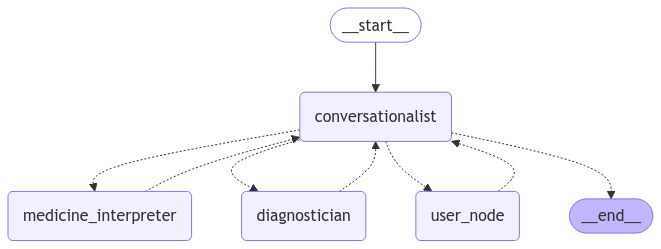

In [109]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [110]:

def trimNavigationalPostFixes(message: str) -> str:
    """Trim the navigational postfixes like @user""" 
    result = message
    if ("@end" in message):
        result = result.replace('@end' , '')
    elif ("@user" in message):
        result = result.replace('@user' , '')
    return result

In [111]:
def clean_debug_print(message: dict):
    # print(message)
    # duplicate calls
    if ('agent' in message and 'messages' in message['agent']):
        add_kwarg = message['agent']['messages'][-1].additional_kwargs
        if 'tool_calls' in add_kwarg:
            # print(add_kwarg['tool_calls'])
            return "tool call: \n" + "\n".join([str(item['function']) for item in add_kwarg['tool_calls']])
        return None
    # user message interrupt
    elif ('__interrupt__' in message):
        return None
    # we know what we wrote.
    elif ('user_node' in message):
        return None
    elif ('conversationalist' in message) and ('messages' in message['conversationalist']):
        # this is covered by default print == Lars L medicin ==
        return None
        # return "conversationalist: \n" +  message['conversationalist']['messages'][-1].content
    elif ('tools' in message and 'messages' in message['tools']):
        return "tool result: \n" +  message['tools']['messages'][-1].content
    elif ('diagnostician' in message and 'messages' in message['diagnostician']):
        return "diagnostician: \n" +  message['diagnostician']['messages'][-1].content
    elif ('medicine_interpreter' in message and 'messages' in message['medicine_interpreter']):
        return "interpreter: \n" +  message['medicine_interpreter']['messages'][-1].content
    else:
        return message
    

In [112]:
import uuid

# set to true for cleaner debug (no meta info)
clean_debug = True

# Convo thread configuration. Not really necessary for this other than for interruption.
# But in a bigger system this would be a must-have.
thread_config = {"configurable": {"thread_id": uuid.uuid4()}, "recursion_limit": 200}

intial_state = {
            "messages": [
                ("system", "Starta konversationen")
            ]
        }
command = Command(update=intial_state)
latest_msg = None

# need the outer loop due to the interrupt-resume mechanics.
while command:
    for s in graph.stream(
        command,        
        subgraphs=True,
        config=thread_config,
    ):
        # NOTE: uncomment these three for full log.
        if not clean_debug:
            print("\n")
            print(s)
            print("----")
        else:
            res = clean_debug_print(s[1])
            if res != None:
                print("\n")
                print(res)
                print("----")
        if ('conversationalist' in s[1]):
            latest_msg = trimNavigationalPostFixes(s[1]['conversationalist']['messages'][-1].content)
        elif ('agent' in s[1] and (s[1]['agent']['messages'][-1].name == 'talk_to_diagnostician' or s[1]['agent']['messages'][-1].name == 'talk_to_medicine_interpreter')):
            latest_msg = trimNavigationalPostFixes(s[1]['agent']['messages'][-1].content)
        elif ('user_node' in s[1]):
            asd = s[1]['user_node']['messages'][-1].content
            print("\n==User Response==", flush=True)
            print(asd, flush=True)
            # print("===================", flush=True)
    next_ = graph.get_state(thread_config).next
    # if no next, aka we are at end, terminate
    if not next_:
        if len(latest_msg) > 1:
            print("\n==Lars L. Medicin==", flush=True)
            print(latest_msg, flush=True)

        command = None
    # get user input
    else:
        print("\n==Lars L. Medicin==", flush=True)
        print(latest_msg, flush=True)
        # print("===================", flush=True)
        command = Command(resume=input())



tool call: 
{'arguments': '{"message":"Hej och välkommen till apoteket! Hur kan jag hjälpa dig idag?"}', 'name': 'talk_to_customer'}
----

==Lars L. Medicin==
Hej och välkommen till apoteket! Hur kan jag hjälpa dig idag?

==User Response==
dagen efter piller 


tool call: 
{'arguments': '{"message":"För att hjälpa dig med dagen efter-piller, kan du berätta hur många timmar det har gått sedan du hade samlag?"}', 'name': 'talk_to_customer'}
----

==Lars L. Medicin==
För att hjälpa dig med dagen efter-piller, kan du berätta hur många timmar det har gått sedan du hade samlag?

==User Response==
33

==Lars L. Medicin==
Så det har gått 33 timmar sedan samlaget, är det korrekt?

==User Response==
jo

==Lars L. Medicin==
Har du några allergier som vi bör känna till?

==User Response==
majsstärkelse

==Lars L. Medicin==
Så du är allergisk mot majsstärkelse, är det korrekt?

==User Response==
jo

==Lars L. Medicin==
Har du några sjukdomar som vi bör känna till?

==User Response==
crohns

==Lar